In [1]:
from bunch import Bunch
import functools
import json
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import palettable
import pandas as pd
from scipy.spatial import ConvexHull
import sys
import pneumodel.plotting as plotting
import pneumodel.trial as pn
import scipy.stats as st
from pneumodel.plotting import style_violin

/Users/ocsicnarf/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
%load_ext autoreload
%autoreload 2

##  Setup

In [29]:
%matplotlib inline
cubehelix = palettable.cubehelix.cubehelix1_16_r.mpl_colors
COLORS  = {'infant': cubehelix[6], 'toddler': cubehelix[10], 'vaccinated': cubehelix[11]}
MARKERS = {'infant': 'o', 'toddler': 's'}

In [30]:
OUTPUT_FOLDER = "/Volumes/Samsung USB/WCV-PAPER/wcv-trial-kenya-beta-0.1"
FIGURES_FOLDER = os.path.join(OUTPUT_FOLDER, 'figures')
save_figure = functools.partial(plotting.save_figure, folder=FIGURES_FOLDER, dpi=300)

## Age distribution 

In [31]:
cfg_path = os.path.join(OUTPUT_FOLDER, 'configuration') 
with open(os.path.join(cfg_path, 'configuration.json')) as f:
  CFG = json.load(f, object_hook=lambda d: Bunch(d))

with open(os.path.join(cfg_path, CFG.population.lifespan_pmf_file)) as f:
  LIFESPAN_PMF = json.load(f, object_hook=lambda d: Bunch(d)).pmf
LIFESPAN_PMF = [0] + LIFESPAN_PMF

['/Volumes/Samsung USB/WCV-PAPER/wcv-trial-kenya-beta-0.1/figures/lifespan-distribution-0.pdf',
 '/Volumes/Samsung USB/WCV-PAPER/wcv-trial-kenya-beta-0.1/figures/lifespan-distribution-0.png']

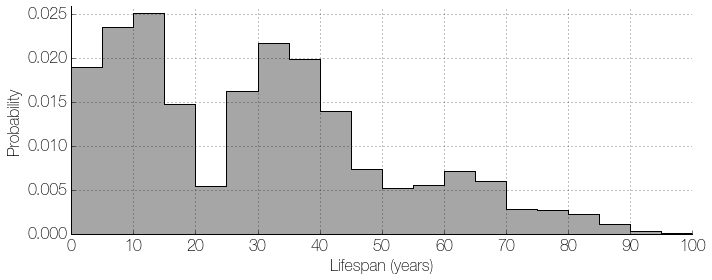

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

yrs = np.arange(len(LIFESPAN_PMF))
ax.step(yrs, LIFESPAN_PMF)

for a, b in zip(yrs[:-1], yrs[1:]):
  ax.fill_between([a, b], 0, LIFESPAN_PMF[b], facecolor='.65', edgecolor='.65', lw=1)


ax.set_ylabel('Probability')
ax.set_ylim(0, max(LIFESPAN_PMF) * 1.03)

ax.set_xlabel('Lifespan (years)')
ax.set_xlim(0, max(yrs) - 1)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(10))

ax.grid(True)
plotting.remove_spines(ax)
fig.tight_layout()
save_figure(fig, 'lifespan-distribution')

## A sample run

In [33]:
%%time
TRA_B = pn.load_trajectories(OUTPUT_FOLDER, index_by='birth')

CPU times: user 2.82 s, sys: 201 ms, total: 3.02 s
Wall time: 1min 17s


In [34]:
TRA_B.keys()

['dr-10ce-toddler',
 'control-infant',
 'control-toddler',
 'dr-5ce-infant',
 'dr-3ce-toddler',
 'dr-3ce-infant',
 'dr-10ce-infant',
 'sr-1.0-6A-infant',
 'sr-1.0-infant',
 'dr-5ce-toddler',
 'sr-0.5-infant']

['/Volumes/Samsung USB/WCV-PAPER/wcv-trial-kenya-beta-0.1/figures/example-using-run-0-1.pdf',
 '/Volumes/Samsung USB/WCV-PAPER/wcv-trial-kenya-beta-0.1/figures/example-using-run-0-1.png']

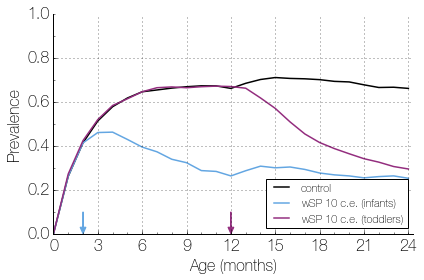

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

run = 'run-0'
num_months = 25
marker='o'
markersize=0

ax.plot(TRA_B['control-infant'][run][:num_months],  c='k', label='control', 
        marker=marker, markersize=markersize, lw=1.5)
ax.plot(TRA_B['dr-10ce-infant'][run][:num_months],  c=COLORS['infant'], label='wSP 10 c.e. (infants)', 
        marker=marker, markersize=markersize, lw=1.5)
ax.plot(TRA_B['dr-10ce-toddler'][run][:num_months], c=COLORS['toddler'], label='wSP 10 c.e. (toddlers)', 
        marker=marker, markersize=markersize, lw=1.5)

ax.arrow(60, 0.1, 0.0, -0.1, fc=COLORS['infant'], ec=COLORS['infant'], 
         head_width=12, head_length=0.03, length_includes_head=True)
ax.arrow(360, 0.1, 0.0, -0.1, fc=COLORS['toddler'], ec=COLORS['toddler'], 
         head_width=12, head_length=0.03, length_includes_head=True)

ax.set_ylabel('Prevalence')
ax.set_ylim(0, 1.0)
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))

ax.set_xlabel('Age (months)')
ax.set_xlim(0, 24 * 30 + 10)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(90))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(30))
ax.set_xticklabels('{:.0f}'.format(x / 30) for x in ax.get_xticks())

ax.grid(True)

ax.legend(loc='lower right', fontsize=11, frameon=True)

plotting.remove_spines(ax)
fig.tight_layout()

save_figure(fig, 'example-using-{}'.format(run), bbox_inches='tight', bbox_extra_artist=[])

## Analysis

### SFig Prev + Duration + Incidence vs Age

In [36]:
%%time
TRIALS = pn.load_trials(OUTPUT_FOLDER)

CPU times: user 46.1 s, sys: 21.6 s, total: 1min 7s
Wall time: 2min 10s


In [37]:
interval_in_months = 6 # interval length (in months)
start_month = 0 # minimum month
end_month = 60 # maximum number of months
SAMPLING_DAYS = np.arange(start_month * 30, end_month * 30 , interval_in_months * 30)
print SAMPLING_DAYS
print SAMPLING_DAYS / 30

[   0  180  360  540  720  900 1080 1260 1440 1620]
[ 0  6 12 18 24 30 36 42 48 54]


In [38]:
%%time
MEAN_DURATIONS = {}
for arm_name in ['control-infant', 'dr-10ce-infant', 'control-toddler', 'dr-10ce-toddler']:
  MEAN_DURATIONS[arm_name] = {}
  for d in SAMPLING_DAYS:
    MEAN_DURATIONS[arm_name][d] = [pn.get_mean_duration(t.arms[arm_name], interval_in_months * 30, first_day=d) for t in TRIALS]

CPU times: user 19.5 s, sys: 2.79 s, total: 22.3 s
Wall time: 26.5 s


In [39]:
%%time
INCIDENCES = {}
for arm_name in ['control-infant', 'dr-10ce-infant', 'control-toddler', 'dr-10ce-toddler']:
  INCIDENCES[arm_name] = {}
  for d in SAMPLING_DAYS:
    INCIDENCES[arm_name][d] = [pn.get_incidence(t.arms[arm_name], interval_in_months * 30, first_day=d) for t in TRIALS]

CPU times: user 36.9 s, sys: 319 ms, total: 37.2 s
Wall time: 37.7 s


33.1065467605
22.48875538
21.6672410312
20.906384555
20.2652966868
19.7495784256
19.3508045654
18.9669348002
18.7221514135
18.5241409782


['/Volumes/Samsung USB/WCV-PAPER/wcv-trial-kenya-beta-0.1/figures/prev-dur-inc-vs-age-infant-0.pdf',
 '/Volumes/Samsung USB/WCV-PAPER/wcv-trial-kenya-beta-0.1/figures/prev-dur-inc-vs-age-infant-0.png']

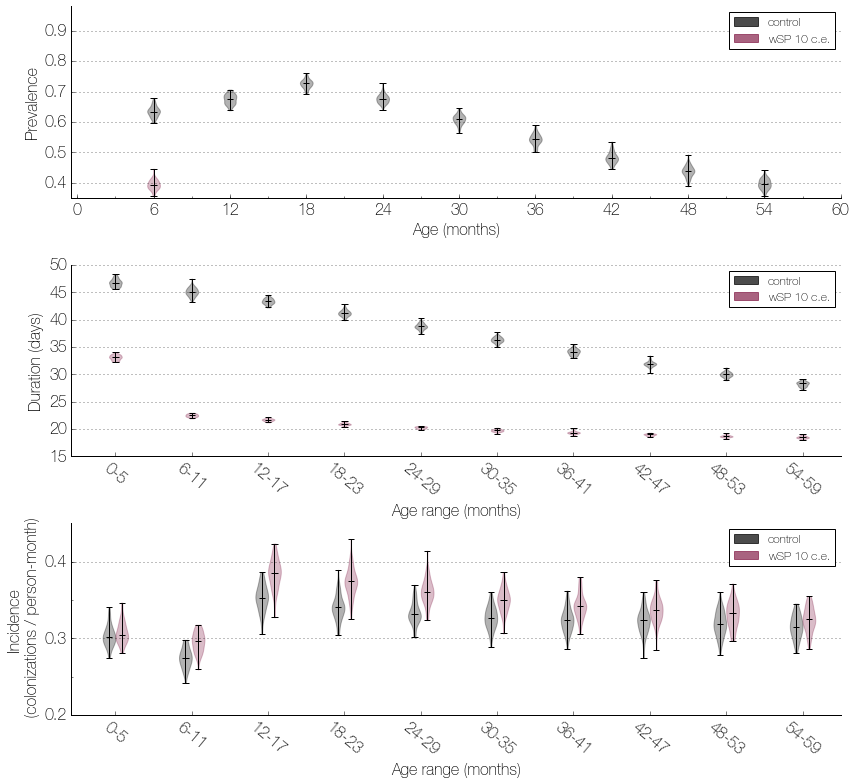

In [40]:
fig, axes = plt.subplots(3, 1, figsize=(12, 11))

dsb_prev = np.arange(start_month * 30, end_month * 30, 3 * 30) # days since birth

age_group = 'infant'
arm_one = 'control-{}'.format(age_group)
arm_two = 'dr-10ce-{}'.format(age_group)

w = 1
delta = 0.5

# Prevalence vs age
ax = axes[0] 
for d in SAMPLING_DAYS:
  
  ys = TRA_B[arm_one].loc[d]
  violin_parts = ax.violinplot(ys, [d / 30], points=80, vert=True, widths=w, 
                               showmeans=False, showextrema=True, showmedians=True)
  style_violin(violin_parts, 'k', 'k')
  
  ys = TRA_B[arm_two].loc[d]
  violin_parts = ax.violinplot(ys, [d / 30], points=80, vert=True, widths=w, 
                               showmeans=False, showextrema=True, showmedians=True)
  style_violin(violin_parts, COLORS['vaccinated'], 'k')

ax.set_ylabel('Prevalence')
ax.set_ylim(0.35, 0.98)  

ax.set_xlabel('Age (months)')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(6))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(3))


# Mean duration  
ax = axes[1]
for d in sorted(SAMPLING_DAYS):
  w = 1.0
  ys = MEAN_DURATIONS[arm_one][d]
  v = ax.violinplot(ys, [d / 30 + interval_in_months / 2], points=80, widths=w,
                    showmeans=False, showextrema=True, showmedians=True)
  style_violin(v, 'k', 'k')
  
  ys = MEAN_DURATIONS[arm_two][d]
  v = ax.violinplot(ys, [d / 30 + interval_in_months / 2], points=80, widths=w,
                    showmeans=False, showextrema=True, showmedians=True)
  style_violin(v, COLORS['vaccinated'], 'k')
  
  print np.mean(ys)

ax.set_xlabel('Age range (months)')
ax.set_xticks(SAMPLING_DAYS / 30 + (interval_in_months / 2))
ax.set_xticklabels(['{:.0f}-{:.0f}'.format(d / 30, d / 30 + (interval_in_months - 1)) for d in SAMPLING_DAYS], rotation=-40)

ax.set_ylabel('Duration (days)')
ax.yaxis.grid(True)



# Incidence
ax = axes[2]
for d in sorted(SAMPLING_DAYS):
  w = 1.0
  ys = 30 * np.array(INCIDENCES[arm_one][d])
  v = ax.violinplot(ys, [d / 30 + interval_in_months / 2 - delta], points=80, widths=w,
                    showmeans=False, showextrema=True, showmedians=True)
  style_violin(v, 'k', 'k')

  ys = 30 * np.array(INCIDENCES[arm_two][d])
  v = ax.violinplot(ys, [d / 30 + interval_in_months / 2 + delta], points=80, widths=w,
                    showmeans=False, showextrema=True, showmedians=True)
  style_violin(v, COLORS['vaccinated'], 'k')

ax.set_xticks(SAMPLING_DAYS / 30 + (interval_in_months / 2))
ax.set_xticklabels(['{:.0f}-{:.0f}'.format(d / 30, d / 30 + (interval_in_months - 1)) for d in SAMPLING_DAYS], rotation=-40)
ax.set_xlabel('Age range (months)')

ax.set_ylabel('Incidence\n (colonizations / person-month)')
ax.yaxis.grid(True)
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))


# more plotting
for ax in axes:
  plotting.remove_spines(ax)
  ax.yaxis.grid(True)
  ax.set_xlim(-0.5)
  
for ax in axes:
  patches = []
  for label, color in {'control': 'k', 'wSP 10 c.e.': COLORS['vaccinated']}.iteritems():
    patches.append(mpl.patches.Patch(color=color, label=label, alpha=0.7))
  lgd = ax.legend(handles=patches, frameon=True, fontsize=12, loc='upper right')
    
fig.tight_layout()
plt.subplots_adjust(hspace=0.35)

save_figure(fig, 'prev-dur-inc-vs-age-{}'.format(age_group))

### SFig Prev vs Age

In [41]:
TRA_B['control-infant'].head()

,run-0,run-1,run-2,run-3,run-4,run-5,run-6,run-7,run-8,run-9,...,run-40,run-41,run-42,run-43,run-44,run-45,run-46,run-47,run-48,run-49
dsb,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
30,0.261514,0.237971,0.256061,0.245744,0.248599,0.261905,0.253307,0.264877,0.234917,0.261566,...,0.258472,0.260408,0.266974,0.243086,0.254607,0.247196,0.258859,0.234456,0.240633,0.255059
60,0.413911,0.394858,0.415530,0.407541,0.402085,0.416149,0.401764,0.423239,0.374297,0.414644,...,0.414008,0.406256,0.422900,0.394293,0.410231,0.393380,0.419808,0.388509,0.392456,0.408552
90,0.513232,0.492555,0.511950,0.516784,0.499498,0.507436,0.493577,0.527119,0.472753,0.506029,...,0.509149,0.492162,0.517463,0.494868,0.498695,0.480514,0.510257,0.474924,0.488428,0.505028
120,0.577965,0.567197,0.560451,0.580145,0.558037,0.565331,0.557163,0.588779,0.526591,0.560386,...,0.567976,0.560966,0.583099,0.552780,0.563179,0.546425,0.572177,0.525742,0.546481,0.576087


['/Volumes/Samsung USB/WCV-PAPER/wcv-trial-kenya-beta-0.1/figures/prevalence-vs-age-control-infant-1.pdf',
 '/Volumes/Samsung USB/WCV-PAPER/wcv-trial-kenya-beta-0.1/figures/prevalence-vs-age-control-infant-1.png']

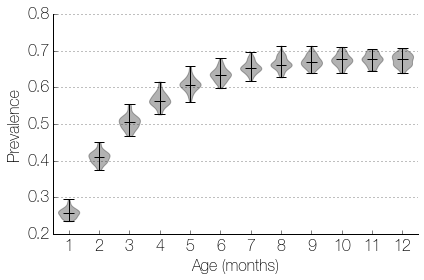

In [42]:
m, n = 1, 13
dsb = [30 * k for k in range(m, n)] # days since birth
arm_name = 'control-infant'

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for d in dsb:
  ys = TRA_B[arm_name].loc[d]
  violin_parts = ax.violinplot(ys, [d / 30], points=100, vert=True, widths=0.7, 
                               showmeans=False, showextrema=True, showmedians=True)
  style_violin(violin_parts, 'k', 'k')

ax.set_xlabel('Age (months)')
ax.set_xlim(m - 0.5, n - 0.5)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))

ax.set_ylabel('Prevalence')
#ax.set_ylim(0.45, 0.95)
ax.yaxis.grid(True)
  
plotting.remove_spines(ax)
fig.tight_layout()

save_figure(fig, 'prevalence-vs-age-{}'.format(arm_name))

###  SFig Duration vs Age

In [43]:
%%time
TRIALS = pn.load_trials(OUTPUT_FOLDER)

CPU times: user 43.3 s, sys: 15.1 s, total: 58.4 s
Wall time: 1min 46s


In [44]:
%%time
L = 6 * 30 # interval length (in days)
m = 1      
n = 10
dsb = np.array([i * L for i in range(m, n)])
arm_name = 'control-toddler'

mean_durations = {}
for d in dsb:
  mean_durations[d] = [pn.get_mean_duration(t.arms[arm_name], L, first_day=d) for t in TRIALS]

CPU times: user 4.03 s, sys: 537 ms, total: 4.57 s
Wall time: 5.15 s


6, 45.16, 43.44, 46.73
12, 43.30, 42.27, 44.32
18, 41.26, 40.26, 42.81
24, 38.77, 37.21, 39.68
30, 36.38, 35.28, 37.93
36, 34.11, 32.53, 35.31
42, 31.97, 31.20, 33.20
48, 30.02, 29.15, 31.00
54, 28.20, 27.35, 29.07


['/Volumes/Samsung USB/WCV-PAPER/wcv-trial-kenya-beta-0.1/figures/duration-vs-age-control-toddler-1.pdf',
 '/Volumes/Samsung USB/WCV-PAPER/wcv-trial-kenya-beta-0.1/figures/duration-vs-age-control-toddler-1.png']

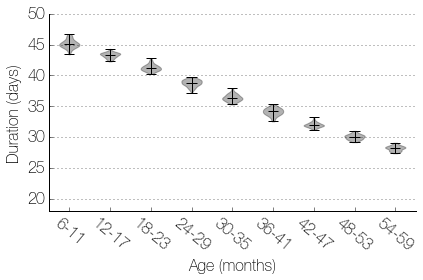

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for d in sorted(mean_durations.iterkeys()):
  ys = mean_durations[d]
  print '{:.0f}, {:.2f}, {:.2f}, {:.2f}'.format(d / 30, np.mean(ys), np.min(ys), np.max(ys))
  v = ax.violinplot(ys, [d / L], points=80, widths=0.5,
                    showmeans=False, showextrema=True, showmedians=True)
  style_violin(v, 'k', 'k')

ax.set_xlabel('Age (months)')
ax.set_xlim(m - 0.5, n - 0.5)
ax.set_xticks(dsb / L)
ax.set_xticklabels(['{:.0f}-{:.0f}'.format(d / 30, d / 30 + (L / 30 - 1)) for d in dsb], rotation=-40)

ax.set_ylabel('Duration (days)')
ax.yaxis.grid(True)
ax.set_ylim(18, 50)

plotting.remove_spines(ax)
fig.tight_layout()
save_figure(fig, 'duration-vs-age-{}'.format(arm_name))

### Figure 2

Read in the data

In [46]:
%%time
TRA_D = pn.load_trajectories(os.path.join(OUTPUT_FOLDER), index_by='last_dose')

CPU times: user 2.2 s, sys: 78.4 ms, total: 2.27 s
Wall time: 2.94 s


Example of the data

In [47]:
TRA_D['control-infant'].head()

,run-0,run-1,run-2,run-3,run-4,run-5,run-6,run-7,run-8,run-9,...,run-40,run-41,run-42,run-43,run-44,run-45,run-46,run-47,run-48,run-49
dsv,,,,,,,,,,,,,,,,,,,,,
-60,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
-30,0.261514,0.237971,0.256061,0.245744,0.248599,0.261905,0.253307,0.264877,0.234917,0.261566,...,0.258472,0.260408,0.266974,0.243086,0.254607,0.247196,0.258859,0.234456,0.240633,0.255059
0,0.413911,0.394858,0.415530,0.407541,0.402085,0.416149,0.401764,0.423239,0.374297,0.414644,...,0.414008,0.406256,0.422900,0.394293,0.410231,0.393380,0.419808,0.388509,0.392456,0.408552
30,0.513232,0.492555,0.511950,0.516784,0.499498,0.507436,0.493577,0.527119,0.472753,0.506029,...,0.509149,0.492162,0.517463,0.494868,0.498695,0.480514,0.510257,0.474924,0.488428,0.505028
60,0.577965,0.567197,0.560451,0.580145,0.558037,0.565331,0.557163,0.588779,0.526591,0.560386,...,0.567976,0.560966,0.583099,0.552780,0.563179,0.546425,0.572177,0.525742,0.546481,0.576087


['/Volumes/Samsung USB/WCV-PAPER/wcv-trial-kenya-beta-0.1/figures/prevalence-sample-size-by-ce-3.pdf',
 '/Volumes/Samsung USB/WCV-PAPER/wcv-trial-kenya-beta-0.1/figures/prevalence-sample-size-by-ce-3.png']

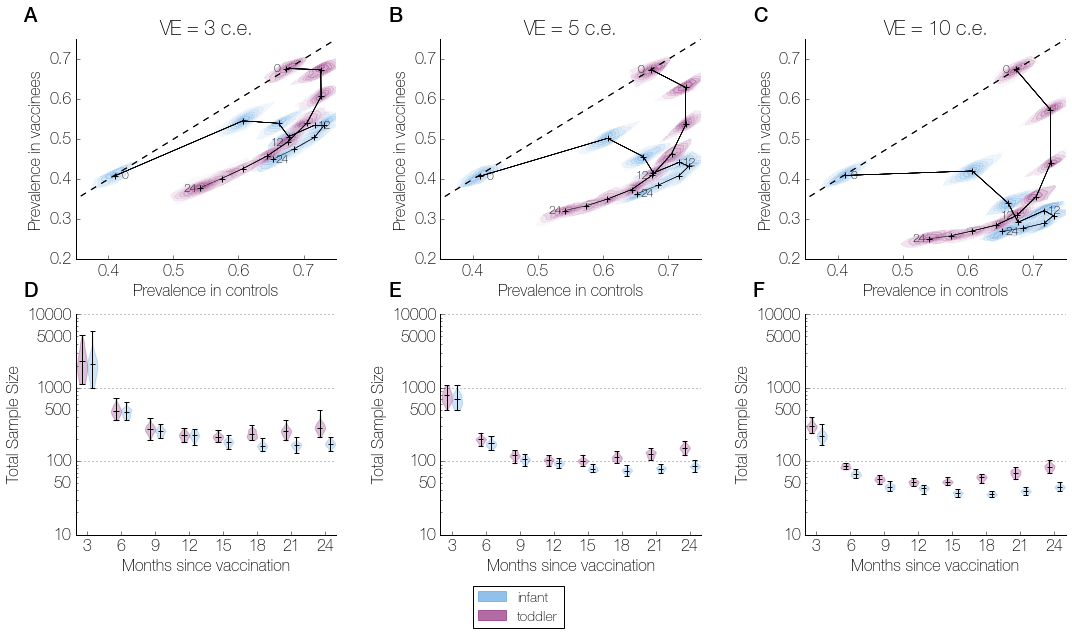

In [49]:
arm_prefixes = ('dr-3ce-{}', 'dr-5ce-{}', 'dr-10ce-{}')
age_groups = ['infant', 'toddler']
dsv = [3 * 30 * k for k in range(9)] # days since vaccination
trajectories = TRA_D
filename = 'prevalence-sample-size-by-ce' # for figure and corresponding text file
textfile = open(os.path.join(FIGURES_FOLDER, filename + '.txt'), 'w')
write = lambda s='': textfile.write(s + '\n')

fig, all_axes = plt.subplots(2, len(arm_prefixes), figsize=(5 * len(arm_prefixes), 8), sharey=False)

#########################################
# Plot prevalence in two arms over time #
#########################################
# Limits for Kenya
# xmin, xmax = 0.45, 0.95
# ymin, ymax = 0.35, 0.95

# Limits for Indonesia
xmin, xmax = 0.35, 0.75
ymin, ymax = 0.2, 0.75

# Limits for random mixing
# xmin, xmax = 0.45, 1.00
# ymin, ymax = 0.35, 0.95

axes = all_axes[0]

for k, age_group in enumerate(age_groups):
  arm_x = 'control-{}'.format(age_group)
  arm_ys = [s.format(age_group) for s in arm_prefixes]

  for ax, arm_y in zip(axes, arm_ys):
    write()
    write(arm_y)
    
    dots = [] # so we can connect the dots later
    for j, d in enumerate(dsv):
      xs = trajectories[arm_x].loc[d]
      ys = trajectories[arm_y].loc[d]
      points = np.array([xs, ys])
      
      xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
      positions = np.vstack([xx.ravel(), yy.ravel()])
      kernel = st.gaussian_kde(points)
      f = np.reshape(kernel(positions).T, xx.shape)

      hull = ConvexHull(points.T)
      hull_points = np.array([points.T[hull.vertices, 0], points.T[hull.vertices, 1]])
      hull_clip_poly = mpl.patches.Polygon(hull_points.T, fc='none', ec=COLORS[age_group], transform=ax.transData, alpha=0.5)
      #ax.add_patch(hull_clip_poly)
      
      cmap = mpl.colors.LinearSegmentedColormap.from_list('mycmap', [(0, 'white'), (1.0, COLORS[age_group])])
      cfset = ax.contourf(xx, yy, f, cmap=cmap, alpha=0.5)
      for c in cfset.collections:
        c.set_clip_path(hull_clip_poly)
        
      ax.plot(np.median(xs), np.median(ys), marker='+', mec='k', mew=1)
      dots.append((np.median(xs), np.median(ys)))
      write('\t({:.0f}, {:.2f}c, {:.2f}v)'.format(d / 30, np.median(xs), np.median(ys)))
    
      if (d / 30) % 12 == 0:
        offset = 0.015
        if k == 0:
          text_x = np.median(xs) + offset
        else:
          text_x = np.median(xs) - offset
        text_y = np.median(ys)
        ax.annotate(str(d / 30), (text_x, text_y), fontsize=12, ha='center', va='center')
        
      # connect the dots
      ax.plot(*zip(*dots), ls='-', lw=0.5, c='k', alpha=1, zorder=10)
      
    # label axes, etc.
    ax.set_xlabel('Prevalence in controls')
    ax.set_xlim(xmin, xmax)
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))

    ax.set_ylabel('Prevalence in vaccinees')
    ax.set_ylim(ymin, ymax)
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))

    lower = min(xmin, ymin)
    upper = max(ymax, xmax)
    ax.plot((lower, upper), (lower, upper), lw=1, ls='--')
    ax.set_title('VE = ' + arm_y.split('ce')[0][3:] + ' c.e.')
    plotting.remove_spines(ax)

    
##############################
# Plot sample size over time #
##############################

axes = all_axes[1]
for k, age_group in enumerate(age_groups):
  arm_x = 'control-{}'.format(age_group)
  arm_ys = [s.format(age_group) for s in arm_prefixes]
  

  for ax, arm_y in zip(axes, arm_ys):
    write()
    write(arm_y)
    for d in dsv:    
      if d == 0:
        continue
        
      xs = trajectories[arm_x].loc[d]
      ys = trajectories[arm_y].loc[d]
      zs = np.array([pn.sample_size(x, y) for (x, y) in zip(xs, ys)])
      
      printwrite('\t({:.0f}, {:.2f})'.format(d / 30, np.median(zs)))
      
      w = 0.9
      xoffset = (2 * (k == 0) - 1) * (w / 2) + 0.02
      violin_parts = ax.violinplot(zs, [d / 30 + xoffset], points=80, vert=True, widths=w,
                      showmeans=False, showextrema=True, showmedians=True)
    
      style_violin(violin_parts, COLORS[age_group], 'k')
    
    ax.set_xlabel('Months since vaccination')
    ax.xaxis.set_ticks([d / 30 for d in dsv])
    ax.xaxis.set_ticklabels(['{:.0f}'.format(x) for x in ax.get_xticks()])
    ax.set_xlim(2, 25)

    ax.set_ylabel('Total Sample Size')
    ax.yaxis.grid(True, which='major')
    ax.set_ylim(1e1, 1e4)
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

    def show_only_some(x, pos):
      s = str(int(x))
      if s[0] in ('5'):
          return s
      return ''
    ax.yaxis.set_minor_formatter(mpl.ticker.FuncFormatter(show_only_some))

    plotting.remove_spines(ax)

panel_labels = []
for label, ax in zip('ABCDEF', all_axes.flatten()):
  t = ax.text(-0.2, 1.08, label, fontsize=20, 
              fontweight='medium', transform=ax.transAxes)
  panel_labels.append(t)
  

ax = all_axes[1][1]
patches = [mpl.patches.Patch(color=COLORS[a], label=a, alpha=0.7) for a in age_groups]
lgd = ax.legend(handles=patches, frameon=True, fontsize=14, bbox_to_anchor=(0.5, -0.2))

fig.tight_layout()
plt.subplots_adjust(hspace=0.25, wspace=0.4)

textfile.close()

save_figure(fig, filename, bbox_inches='tight', bbox_extra_artist=[panel_labels] + [lgd])